/var/folders/xr/cv4msgs94jq0nw15cwkskrbc0000gn/T/ipykernel_36118/2758959625.py:63: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  XG = fsolve(F, XG_guess)


0 299.9999999999991 13.335050769529746 -23.081796636467725
11 299.99999999999955 5.76752706230612 -11.137091980730697
16 299.9999999999991 -5.517629576539171 14.362564649093722


/var/folders/xr/cv4msgs94jq0nw15cwkskrbc0000gn/T/ipykernel_36118/2758959625.py:63: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  XG = fsolve(F, XG_guess)


898 299.99999999999955 7.87281599284585 -12.14060759447706
903 299.99999999976717 -48.143000978493035 102.42392869644084


Text(0, 0.5, 'T (K)')

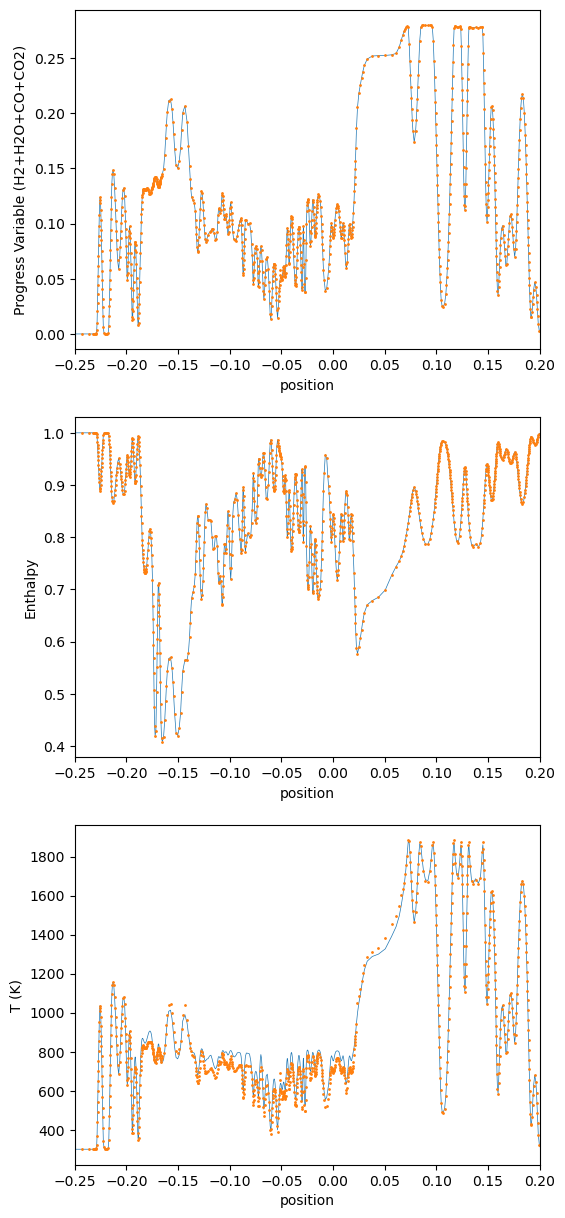

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator as RGI
from scipy.interpolate import LinearNDInterpolator as LNDI
from scipy.optimize import fsolve

#####################

nf = 102
nX= 24             # number of chi values
nG = 13            # number of heat loss values (G for gamma)

fgrid = np.linspace(0,1,nf)              # table coordinates
Xgrid = np.arange(nX, dtype=np.float64)  # parametric, not actual χ
Ggrid = np.arange(nG, dtype=np.float64)  # parametric, not actual G
#Ggrid = np.linspace(0.0,0.6,nG)

c = np.zeros((nf, nX, nG))
h = np.zeros((nf, nX, nG))
T = np.zeros((nf, nX, nG))

###################################

for iL in range(nX):
    for it in range(nG):
        fname = "flm_" + str(iL).zfill(2) + '_' + str(it).zfill(2) + ".dat"
        data = np.loadtxt(fname)

        ii = interp1d(data[:,1], data[:,4])       # mixf, c
        c[:,iL, it] = ii(fgrid)

        ii = interp1d(data[:,1], data[:,3])       # mixf, h
        h[:,iL, it] = ii(fgrid)

        ii = interp1d(data[:,1], data[:,2])       # mixf, T
        T[:,iL, it] = ii(fgrid)

#####################

hmax = np.max(h)
hmin = np.min(h)
h = (h-hmin)/(hmax-hmin)

#####################

cI = RGI((fgrid, Xgrid, Ggrid), c, bounds_error=False, fill_value=None, method='linear')      # call as cI([fvalue, Lvalue, tvalue])
hI = RGI((fgrid, Xgrid, Ggrid), h, bounds_error=False, fill_value=None, method='linear')      
TI = RGI((fgrid, Xgrid, Ggrid), T, bounds_error=False, fill_value=None, method='linear')

#####################

def get_XG(f, h, c, XG_guess=np.array([0.0,7.0])):

    def F(XG):
        X = XG[0]
        G = XG[1]
        F0 = hI([f, X, G])[0] - h
        F1 = cI([f, X, G])[0] - c
        return np.array([F0, F1])

    XG = fsolve(F, XG_guess)
    
    X = XG[0]
    G = XG[1]
    return X, G

######################
    
odt = np.loadtxt('../ODT/data/tjet_Le1B/data/data_00000/dmp_00012.dat')     # 9, 10, 11, 12
xodt = odt[:,0]
Todt = odt[:,7]
hodt = (odt[:, 28]-hmin)/(hmax-hmin)
codt = odt[:, 11] + odt[:,16] + odt[:,22] + odt[:,23]
fodt = odt[:,8]
fodt[fodt<0.0] = 0.0; fodt[fodt>1.0] = 1.0

nodt = len(fodt)
TT = np.zeros(nodt)
cc = np.zeros(nodt)
hh = np.zeros(nodt)
XG_guess = np.array([1.0, 2.0])
for i in range(nodt):
    X, G = get_XG(fodt[i], hodt[i], codt[i], XG_guess)
    TT[i] = TI([fodt[i], X, G])[0]
    cc[i] = cI([fodt[i], X, G])[0]
    hh[i] = hI([fodt[i], X, G])[0]
    #XG_guess = np.array([X, G])
    
    #if i%10==0: print(X,G)
    #if i%20==0: print(np.abs((codt[i]-cc[i])/codt[i]))
    #if i%20==0: print(i, hI([fodt[i],X,G])[0]-hodt[i], cI([fodt[i],X,G])[0]-codt[i])
    #if i%2==0: print(i, X, G, hI([fodt[i],X,G])[0], hodt[i], cI([fodt[i],X,G])[0],codt[i])
    if TT[i] < 300: print(i,TT[i], X,G)

#------------------------

dof = False

plt.figure(figsize=(6,15))
plt.subplot(3,1,1)
plt.plot(fodt if dof else xodt, codt, '-', lw=0.5)
plt.plot(fodt if dof else xodt, cc, 'o', ms=1, lw=0.5)
if not dof: plt.xlim([-0.25,0.2])
if dof: 
    plt.xlabel('mixture fraction')
else:
    plt.xlabel('position')
plt.ylabel('Progress Variable (H2+H2O+CO+CO2)')


plt.subplot(3,1,2)
plt.plot(fodt if dof else xodt, hodt, '-', lw=0.5)
plt.plot(fodt if dof else xodt, hh, 'o', ms=1, lw=0.5)
if not dof: plt.xlim([-0.25,0.2])
if dof: 
    plt.xlabel('mixture fraction')
else:
    plt.xlabel('position')
plt.ylabel('Enthalpy')

plt.subplot(3,1,3)
plt.plot(fodt if dof else xodt, Todt, '-', lw=0.5)
plt.plot(fodt if dof else xodt, TT, 'o', ms=1, lw=0.5)
if not dof: plt.xlim([-0.25,0.2])
#plt.ylim([100,2300])
if dof: 
    plt.xlabel('mixture fraction')
else:
    plt.xlabel('position')
plt.ylabel('T (K)')
#plt.savefig('t2_position.pdf')